# Forecasting: XGBoost

### Import Libraries and Load Data

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore")

full_data = pd.read_csv("./data/goog.csv", usecols=[0, 1, 2, 3, 4, 5], parse_dates=True)

Check missing values

In [7]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2989 entries, 0 to 2988
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2989 non-null   object 
 1   Open    2989 non-null   float64
 2   High    2989 non-null   float64
 3   Low     2989 non-null   float64
 4   Close   2989 non-null   float64
 5   Volume  2989 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 140.2+ KB


In [8]:
full_data.isnull().sum().any()

False

In [9]:
full_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,2989.0,5.458180e+02,1.961178e+02,99.190173,4.353007e+02,5.380824e+02,6.267000e+02,1.226802e+03
High,2989.0,5.510774e+02,1.967789e+02,101.740174,4.410407e+02,5.420024e+02,6.318411e+02,1.228882e+03
Low,2989.0,5.399927e+02,1.951468e+02,95.960165,4.284907e+02,5.329720e+02,6.205111e+02,1.218602e+03
Close,2989.0,5.455556e+02,1.960029e+02,100.010169,4.351108e+02,5.373600e+02,6.256511e+02,1.220172e+03
Volume,2989.0,8.722729e+06,8.522202e+06,7900.000000,3.489900e+06,5.977000e+06,1.144020e+07,8.254150e+07


### General Observations
1. The dataset contains 2989 observations.
2.  The attributes are all numeric except for a date column.
3.  There are no missing values in the dataset.
4.  The variable Close can be used as a target for the models.

Lets convert the date column into something XGBoost can use

In [10]:
full_data["Date"] = pd.to_datetime(full_data["Date"])

full_data["year"] = full_data["Date"].dt.year
full_data["month"] = full_data["Date"].dt.month
full_data["day"] = full_data["Date"].dt.day
full_data["dayofweek"] = full_data["Date"].dt.dayofweek
full_data["is_month_end"] = full_data["Date"].dt.is_month_end.astype(int)

In [20]:
full_data.head()

,Date,Open,High,Low,Close,Volume,year,month,day,dayofweek,is_month_end
0,2016-07-01,692.200012,700.650024,692.130005,699.210022,1342700,2016,7,1,4,0
1,2016-06-30,685.469971,692.320007,683.650024,692.099976,1590500,2016,6,30,3,1
2,2016-06-29,683.000000,687.429016,681.409973,684.109985,1928500,2016,6,29,2,0
3,2016-06-28,678.969971,680.330017,673.000000,680.039978,2116600,2016,6,28,1,0
4,2016-06-27,671.000000,672.299988,663.283997,668.260010,2629000,2016,6,27,0,0


Note: If we had categorical columns, we would need to identify them and encode them or extract a feature from it

## Find High Correlated Columns

Correlation measures the strength and direction of a linear relationship between two numerical variables. It ranges from -1 to 1:
- +1: perfect positive correlation (they move together)
- 0: no linear relationship
- -1: perfect negative correlation (they move in opposite directions)

Understanding correlation helps identify redundant features in a dataset. Removing highly correlated columns can simplify models, reduce overfitting, and improve performance.

In [26]:
# get pairwise correlation matrix between numeric columns
corr = full_data.corr(numeric_only=True)

# get the absolute values, now our only interest is to know if they're highly correlated
cor_matrix = corr.abs()
upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))

# set a correlation threshold
corr_th=0.90

# Create a list of columns to frop in case thye have a higher correlation than the thrshold
drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
drop_list

['High', 'Low', 'Close']

When analyzing feature correlation, we often remove highly correlated input variables to reduce redundancy and improve model performance. However, if a **column is your target variable** (the one you’re trying to predict), it **should never be dropped**, even if it’s highly correlated with other features. In fact, a strong correlation between features and the target is often a **good sign**, as it means the model can learn meaningful relationships. You should only drop **input features** that are highly correlated with each other — not with the target.

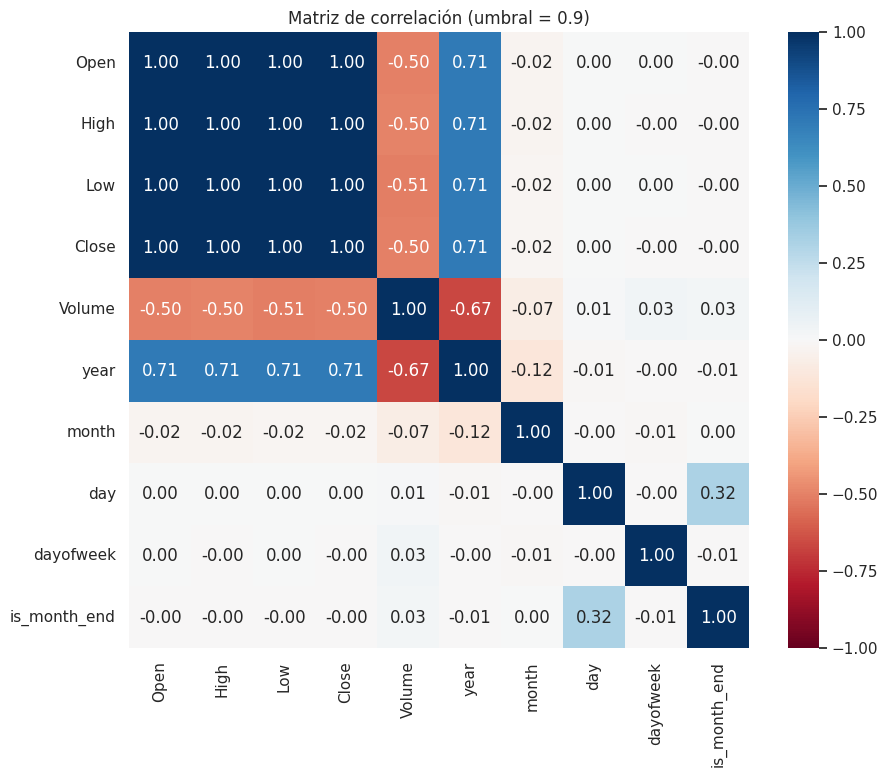

In [25]:
# plot matrix heatmap
sns.set(rc={'figure.figsize': (10, 8)})
sns.heatmap(corr, cmap="RdBu", annot=True, fmt=".2f", vmin=-1, vmax=1)
plt.title(f"Matriz de correlación (umbral = {corr_th})")
plt.show()

Instead of keeping multiple highly correlated features like `High` and `Low`, we can take advantage of their relationship by engineering a **new, more informative feature**. 

For example, the difference between `High` and `Low` reflects the daily price range, which captures volatility in a single value. This reduces redundancy while preserving valuable information. By creating a feature like `price_range = High - Low`, we simplify the model input without losing predictive power.

In [38]:
full_data["price_range"] = full_data["High"] - full_data["Low"]
full_data.head()

,Date,Open,High,Low,Close,Volume,year,month,day,dayofweek,is_month_end,price_range
0,2016-07-01,692.200012,700.650024,692.130005,699.210022,1342700,2016,7,1,4,0,8.520019
1,2016-06-30,685.469971,692.320007,683.650024,692.099976,1590500,2016,6,30,3,1,8.669983
2,2016-06-29,683.000000,687.429016,681.409973,684.109985,1928500,2016,6,29,2,0,6.019043
3,2016-06-28,678.969971,680.330017,673.000000,680.039978,2116600,2016,6,28,1,0,7.330017
4,2016-06-27,671.000000,672.299988,663.283997,668.260010,2629000,2016,6,27,0,0,9.015991


## Normality of Numerical Values

The **Shapiro-Wilk test** is a statistical test used to assess whether a numeric variable is **normally distributed**.
- Null hypothesis (H₀): the data **follows** a normal distribution.
- Alternative hypothesis (H₁): the data **does not** follow a normal distribution.

If the **p-value < 0.05**, we reject the null hypothesis — meaning the data is **not normally distributed**.

In [37]:
print("\n📊 Shapiro-Wilk Normality Test Results📊")
print("==========================================\n")

num_cols = [col for col in full_data.columns if full_data[col].dtypes in ["int", "float"]]

for col in num_cols:
    stat, p = shapiro(full_data[col].dropna())  
    if p > 0.05:
        result = "✅ Likely Normally Distributed"
    else:
        result = "❌ Not Normally Distributed"

    print(f"📌 **{col}**\n   - p-value: {p:.5f} → {result}\n")


📊 Shapiro-Wilk Normality Test Results📊

📌 **Open**
   - p-value: 0.00000 → ❌ Not Normally Distributed

📌 **High**
   - p-value: 0.00000 → ❌ Not Normally Distributed

📌 **Low**
   - p-value: 0.00000 → ❌ Not Normally Distributed

📌 **Close**
   - p-value: 0.00000 → ❌ Not Normally Distributed

📌 **Volume**
   - p-value: 0.00000 → ❌ Not Normally Distributed

📌 **is_month_end**
   - p-value: 0.00000 → ❌ Not Normally Distributed

📌 **price_range**
   - p-value: 0.00000 → ❌ Not Normally Distributed



We can check this nornality in a visual way, as well, let's plot an what an example of a Normal Distribution would look like:

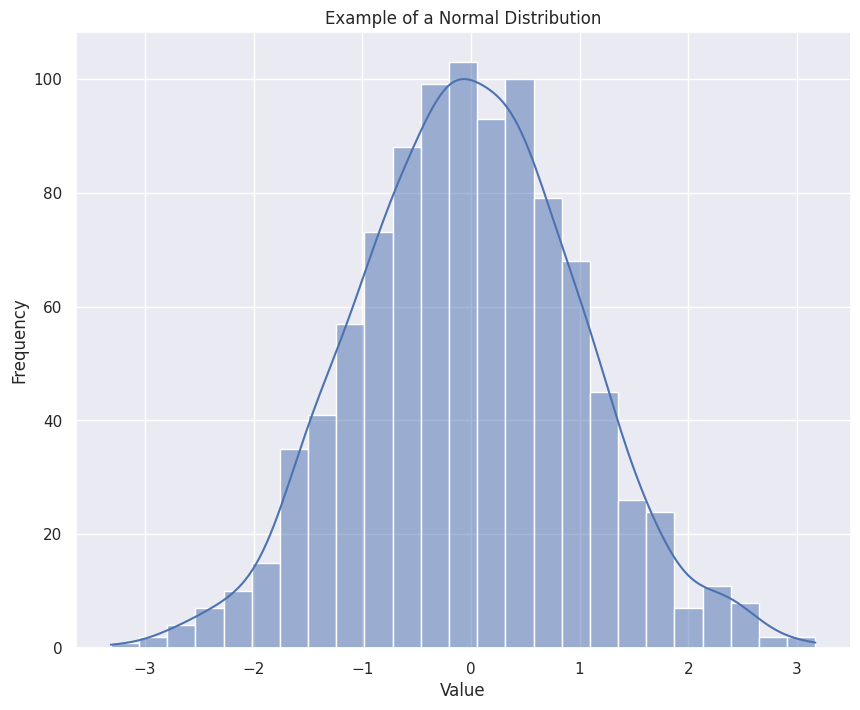

In [43]:
# simulate normal values
data = np.random.normal(loc=0, scale=1, size=1000)

# plot
sns.histplot(data, kde=True)
plt.title("Example of a Normal Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

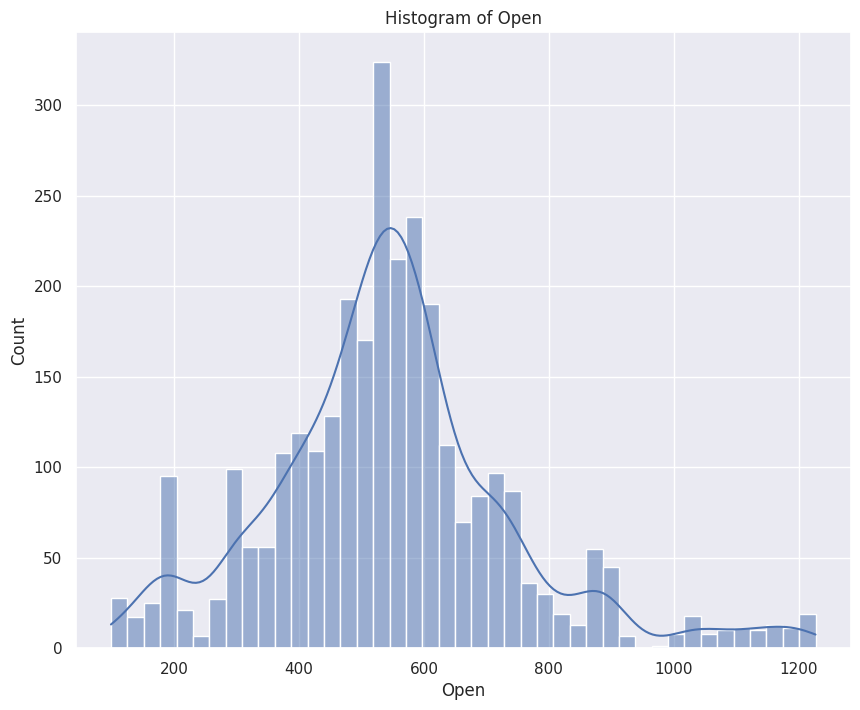

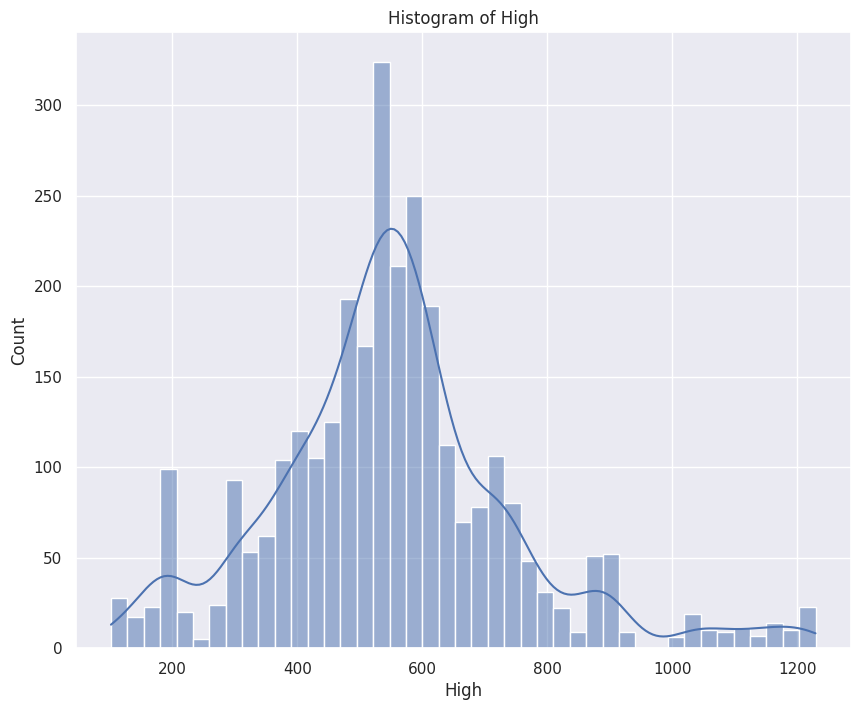

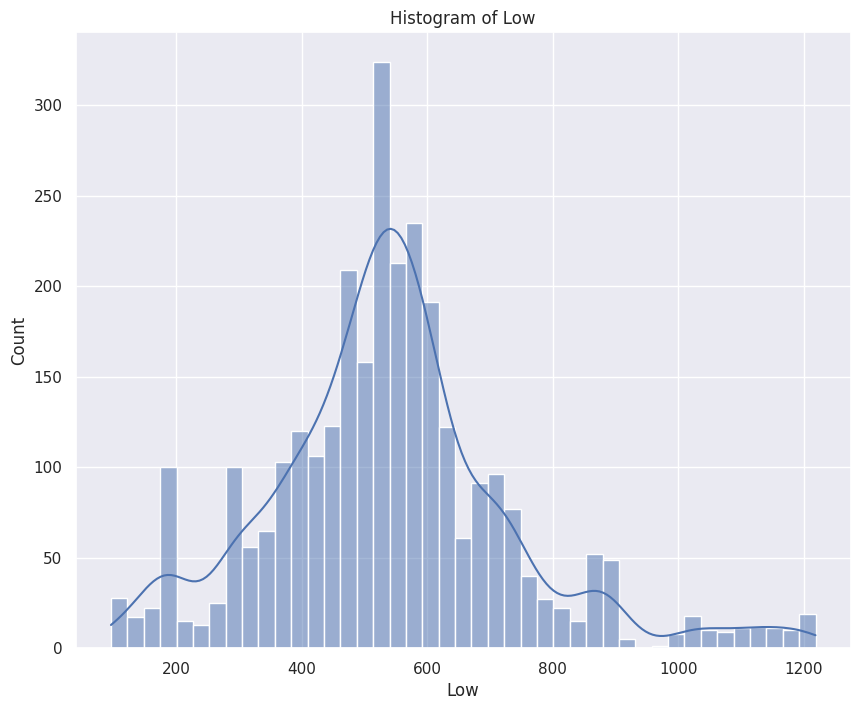

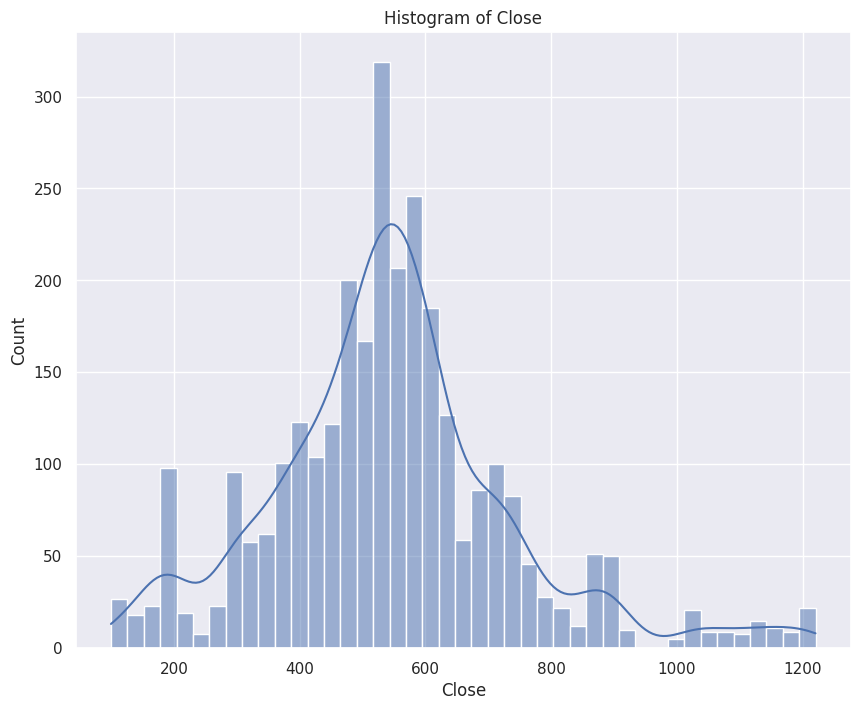

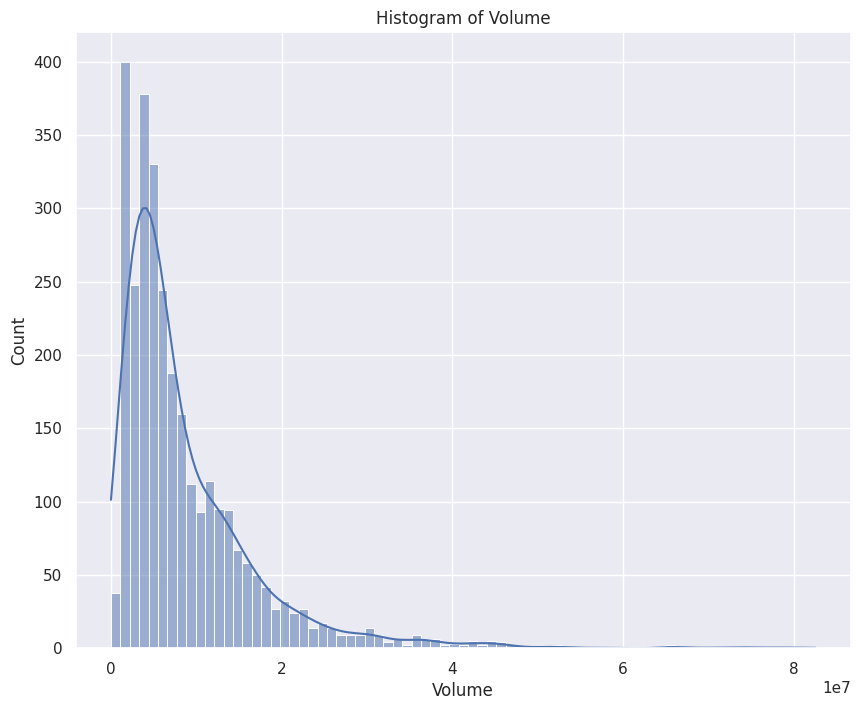

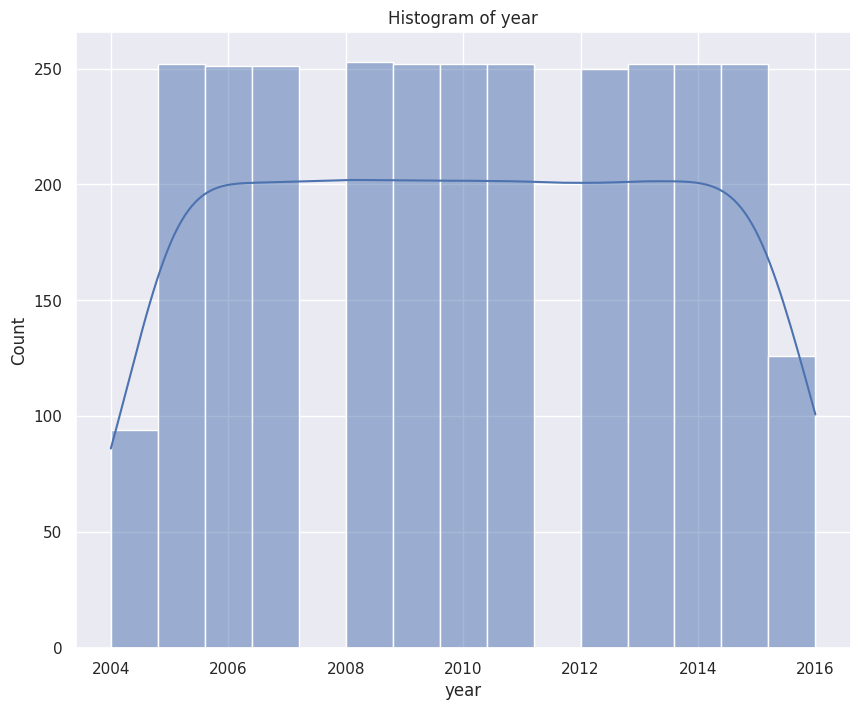

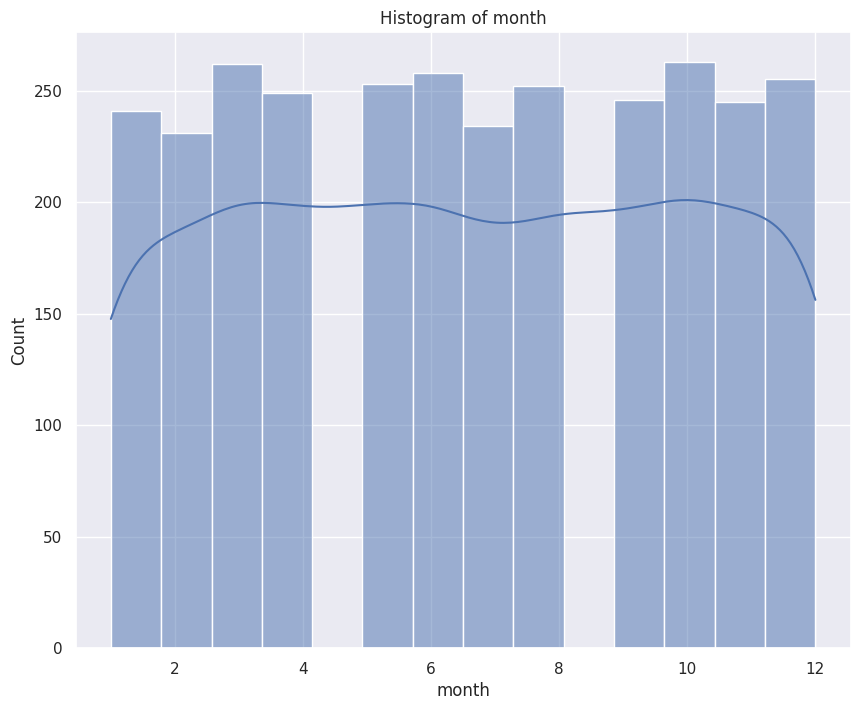

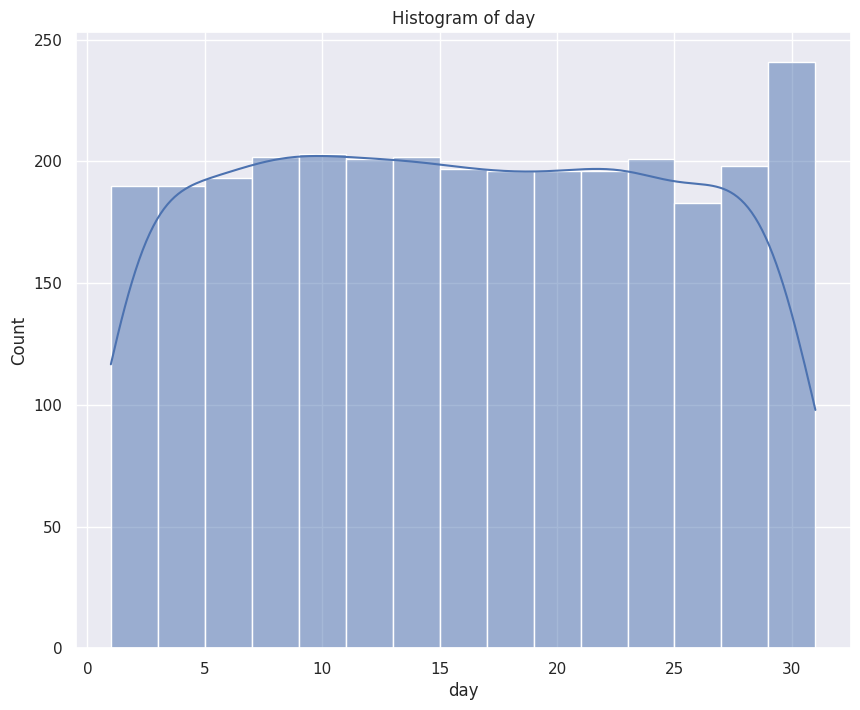

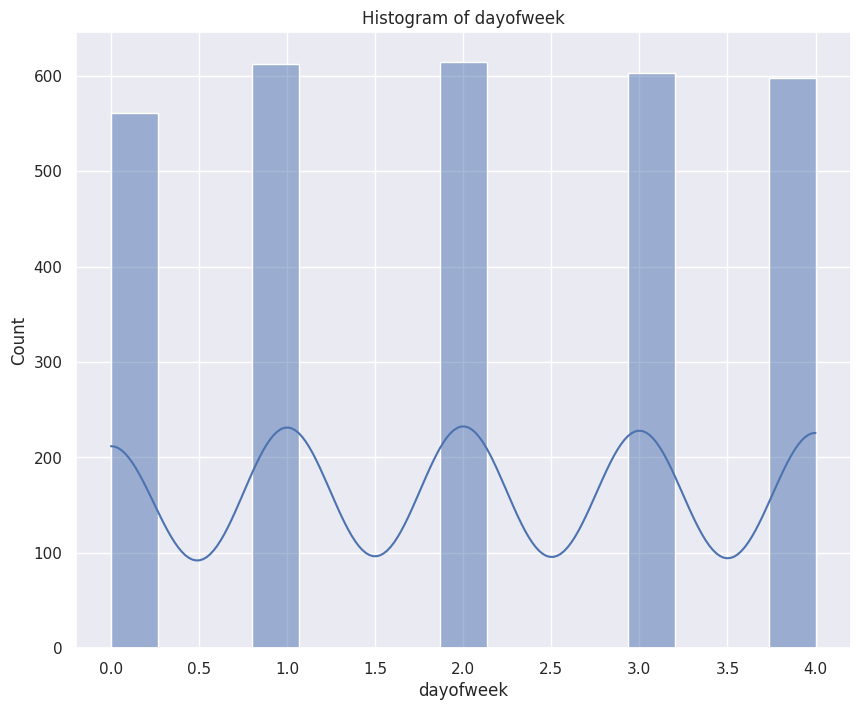

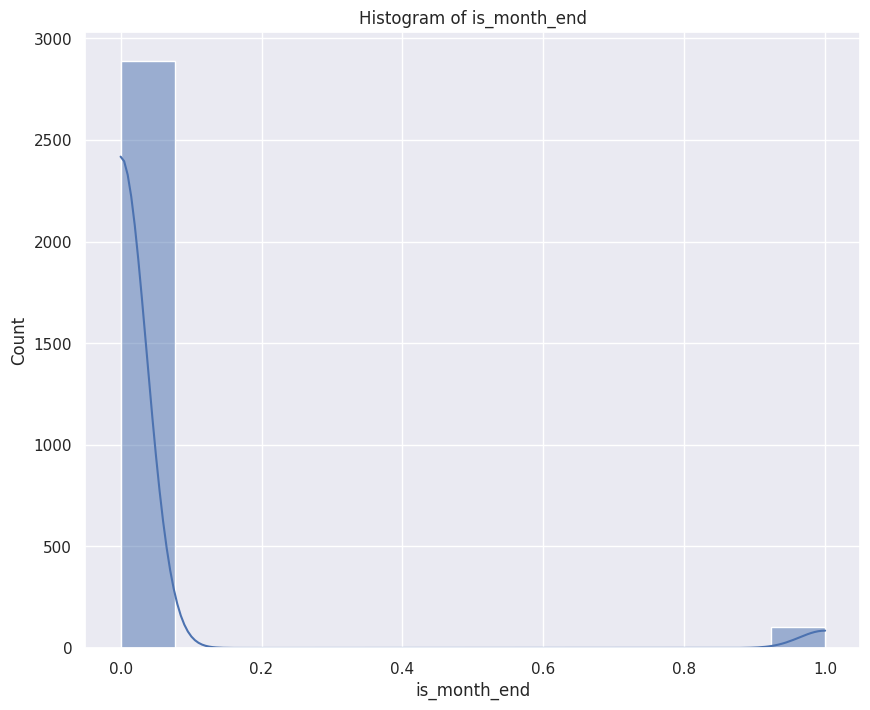

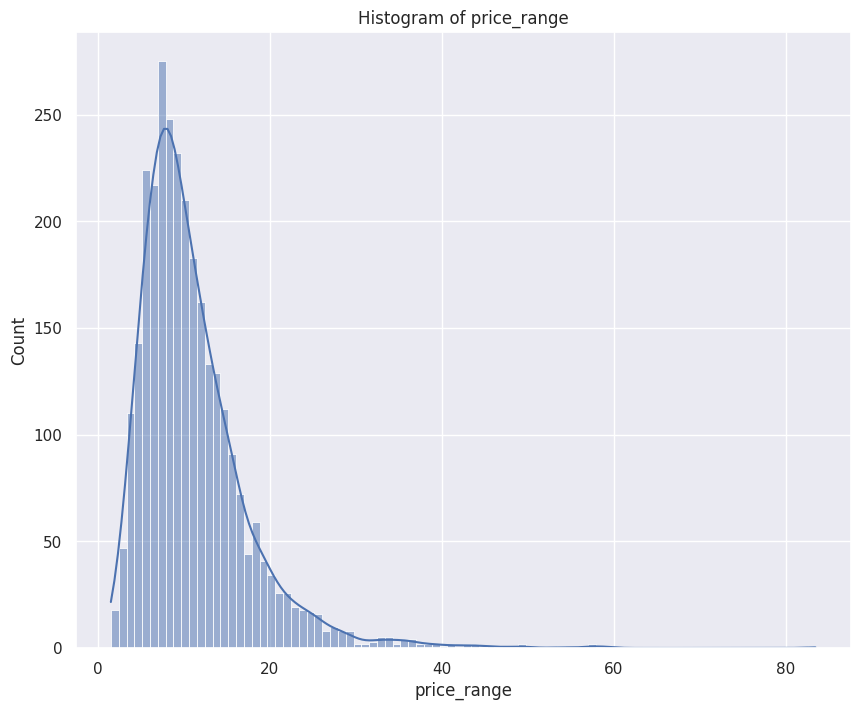

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# cols_to_plot = []

for col in numeric_cols:
    plt.figure()
    sns.histplot(full_data[col], kde=True)
    plt.title(f"Histogram of {col}")
    plt.show()

## Summmary of observations

### General Observations
- The dataset contains **2,989 rows** and **6 numerical columns**, plus one **date column**.
- There are **no missing values** in the dataset.
- All columns are numeric except for the **`Date`** column, which can be used later for time-based features.
- The **`Close`** column is a good candidate for the **target variable** in predictive models.

---

### Correlation Analysis

- We found that **`High`**, **`Low`**, and **`Close`** are **highly correlated** (correlation > 0.90).
- Since `Close` will be used as the **target**, it should **not be dropped**, even if it's highly correlated with other features.
- To reduce feature redundancy, we engineered a new variable:
  ```python
  full_data["price_range"] = full_data["High"] - full_data["Low"]

---

### Normality Testing
- We applied the **Shapiro-Wilk test to check** for normal distribution in numeric variables.
- All features returned **p-values < 0.0001**, meaning we **reject the null hypothesis** of normality.
- This indicates that the variables are **not normally distributed**, which is common in financial datasets due to **skewness** and **outliers**.
- However, since we plan to use tree-based models like XGBoost, **normality is not required** and does not impact model performance.

## Preparing Data for Training

Drop those columns we decided aren't going to add any value or that the model can't handle. 

Here we'll separate a 10% of the data for later testing and split de target variable as well.

In [74]:
n = len(full_data)
test_size = int(n * 0.1)

train = full_data.iloc[:-test_size]
test = full_data.iloc[-test_size:]

columns_to_drop = ['Date','High', 'Low']

X = train.copy()
y = X.pop('Close')
X.drop(columns_to_drop, axis = 1, inplace = True)

In [75]:
X.shape, y.shape

((2691, 8), (2691,))

Split into Train and Validation Split

In [76]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

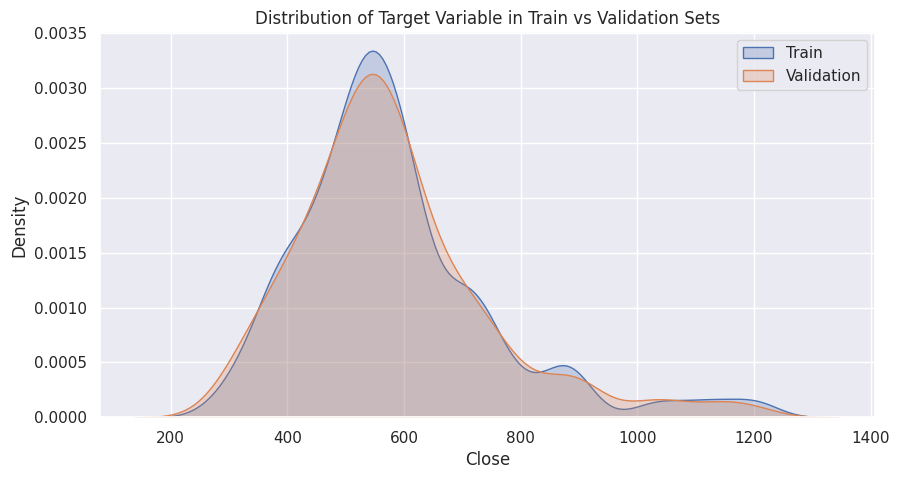

In [77]:
plt.figure(figsize=(10, 5))
sns.kdeplot(y_train, label='Train', fill=True)
sns.kdeplot(y_val, label='Validation', fill=True)
plt.title("Distribution of Target Variable in Train vs Validation Sets")
plt.legend()
plt.show()

Note: [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html)

If we had categorial columns or missing values in pur columns, we'd need to implement some preprocessing steps with sklearn's preprocessing capabilities, something like:

```python
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, new_cat_cols),
    ('num', numerical_transformer, new_num_cols)
])

## Define Machine Learning Models and Params to use

In [78]:
# In case we want to test more models, here we can add them in the dicts
models = {
    'XGBoost': XGBRegressor(random_state=42, verbosity=0)
}

# we would also need to stablish parameters for those model here
param_grid = {
    'XGBoost': {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__max_depth': [3, 5],
    'classifier__min_child_weight': [1, 3],
    'classifier__subsample': [0.8],
    'classifier__colsample_bytree': [0.8]
    }
}

## Hyperparameter Optimization

To optimize model performance, we will use [**Grid Search**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html), a technique that systematically explores a predefined set of hyperparameters. This method evaluates all possible combinations using cross-validation to find the configuration that yields the **best results** for the given task.

In [79]:
# Keep results
best_models = {}
model_scores = []

for model_name, model in models.items():
    print(f"🔍 Training & Tuning {model_name}...")

    # Find best params
    grid_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid[model_name],
        n_iter=20,
        cv=3,
        scoring='r2',
        n_jobs=-1,
        random_state=42
    )
    grid_search.fit(X_train, y_train)

    # Keep best model
    best_models[model_name] = grid_search.best_estimator_

    # Predict
    y_pred = grid_search.best_estimator_.predict(X_val)

    # Evaluate
    r2 = r2_score(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_pred)

    # Keep scores
    model_scores.append([model_name, r2, mse, rmse, mae])

    # Log summary
    print(f"✅ Finished training {model_name}")
    print(f"   R²: {r2:.4f} | MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f}")
    print("------------------------------------------------------")

🔍 Training & Tuning XGBoost...
✅ Finished training XGBoost
   R²: 0.9968 | MSE: 89.2431 | RMSE: 9.4469 | MAE: 6.9106
------------------------------------------------------


In [81]:
scores_df = pd.DataFrame(model_scores, columns=["Model", "R²", "MSE", "RMSE", "MAE"])
scores_df

,Model,R²,MSE,RMSE,MAE
0,XGBoost,0.996814,89.243118,9.446858,6.910645


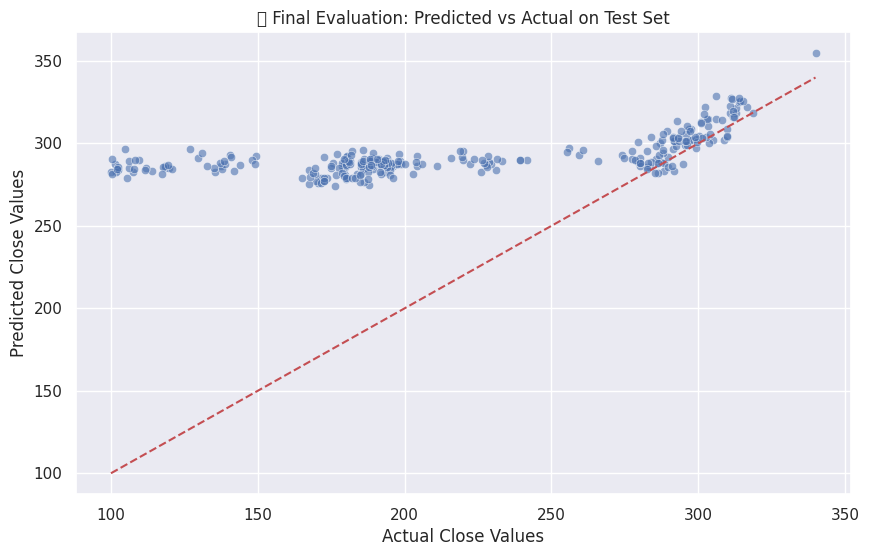

In [83]:
X_test = test.copy()
y_test = X_test.pop('Close')
X_test.drop(columns_to_drop, axis = 1, inplace = True)

# Usamos el mejor modelo, por ejemplo XGBoost
final_model = best_models['XGBoost']

# Predicción sobre el test set
y_test_pred = final_model.predict(X_test)

# Gráfico Predicted vs Actual
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')  # Línea ideal
plt.xlabel('Actual Close Values')
plt.ylabel('Predicted Close Values')
plt.title('📈 Final Evaluation: Predicted vs Actual on Test Set')
plt.grid(True)
plt.show()